<a href="https://colab.research.google.com/github/0xfffddd/Coding/blob/main/MGMT687_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Q1.a.** Explain why directly predicting the optimal price is not an appropriate objective in this setting. Clearly distinguish between price prediction and price optimization.

Answer:

Because **the optimal price is a result closely tied to market requirements and business** decisions, the optimal price is usually affected by:

1. the company’s business strategy, such as pursuing higher profit and revenue or achieving market share targets;
2. constraints from regulatory requirements, competitor restrictions, and historical price constraints;
3. market demand for the product and customer behavior.

In the dataset pricing.csv, almost every column is mainly related to customer behavior (category, gender, rating, etc.) and some company strategy (such as discount). This means it does not include all potential factors related to determining the optimal price (and the optimal price itself does not appear as a column in the dataset).
Meanwhile, if we train a model to predict price directly, it will only estimate price based on historical data under past objectives, rather than predict the best price under current market conditions, constraints, and business goals.

**The difference of price prediction and optimization is:**

Price Prediction estimates what the price will be, meaning it forecasts market price based on historical data. It is usually used when a company is a price taker and not able to influence price significantly. In prediction, the business model focuses on predicting price directly as the outcome.

Price Optimization decides what the price should be, meaning it chooses the price that is most suitable for the company’s business goals. It is usually used when a company has pricing power and can influence the price. In optimization, the business model not only predicts customer responses (buy or not, conversion, CTR, etc.), but also optimizes business goals and selects the best price.



# **Q1.b.** Please explain why prices depend on business objectives rather than having a single ground truth value.

Because price is a decision variable rather than labeled numeric data, the same customer may result in different demand reactions and different optimal prices when the company has different business goals (such as maximizing profit, increasing or maintaining market share, or building long-term customer value). Therefore, there is no single “ground truth” price that can be directly learned from the dataset, since different objectives will lead to different optimal price decisions even under the same demand conditions.

In the homework dataset, we are also trying to build a purchase-probability prediction model instead of predicting a single ground-truth price value. Once we have this model, we are able to represent product demand and the company can predict business outcomes under different business goals (for example, how purchase probability changes under different discounts, or which price would better improve rating or maximize profit). This means the model first predicts customer response to price, and then the firm chooses the price that maximizes its objective. Thus, price does not only rely on historical data (as a ground-truth value), but also on the relationship between business goals and predicted customer behavior under different price levels.

Also, historical prices in the dataset only reflect past business strategies and past objectives at that time, rather than a universally optimal price. If business goals change, such as shifting from maximizing revenue to maximizing long-term profit, the optimal price would also change.

As stated in Q1.a, business strategy, constraints, market demand for the product, and customer behavior all contribute to the optimal price. This is another reason why price depends on business objectives rather than a single ground-truth value. Therefore, price should be determined through optimization based on predicted demand and current business objectives, rather than directly predicted as a fixed value from historical data.


# **Q2.**

Methdology for the model:

In this problem, we will use logistic regression (as recommended in class), since it is very suitable for outputting probabilities in the 0–1 range, which is appropriate for AI-driven pricing decisions.

We will choose the related variables (price, discount, rating, category, etc.) and drop the non-related variables (transaction ID, product ID). Although timestamp may contribute to purchase probability, it can be classified at the hour level, day level, weekday level, or seasonal level, which would make the prediction model very complicated. Therefore, we consider Purchase_Timestamp as a non-related variable and drop it from the model. Customer ID may also affect probability (as different person have different characteristic), but as the customers are much enough, we consider each customer has averange behavior and not effect to the probability.

We will use 80% of the dataset to build the model with 5-fold cross-validation, and the remaining 20% will be used to test the model. We will report AUC, Log Loss, Accuracy, and the Confusion Matrix to evaluate and discuss the model’s performance. Also we used threshold of probability = 0.5 as default choice.

We will also output the median and mode for each category, as they may be used in Question 3.

In [5]:
#Code for Q2
#step1 import libiary
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, confusion_matrix

#step2 load the data and define variables
df = pd.read_csv("pricing.csv")
# result = purchase probability
y = df["Purchase Probability"].astype(int)
# predictor = other column but dropped result, IDs, timestamp.
X = df.drop(columns=[
    "Purchase Probability",
    "Transaction_ID", "Customer_ID", "Product_ID",
    "Purchase_Timestamp"
], errors="ignore")

#step3 pre-processing
#separate the numeric data and category data
num_cols = ["Price", "Discount", "Customer_Age", "Review_Rating"]
num_cols = [c for c in num_cols if c in X.columns]
cat_cols = [c for c in X.columns if c not in num_cols]
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])
#define the regression model
modelprob = Pipeline([
    ("prep", preprocess),
    ("lr", LogisticRegression(max_iter=2000))
])
#split the data with 20% for test, 80% for regression with 5 fold CV
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=26, stratify=y
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

trainval_prob = cross_val_predict(
    modelprob, X_trainval, y_trainval,
    cv=cv, method="predict_proba"
)[:, 1]
#define evaluation metric
cv_auc = roc_auc_score(y_trainval, trainval_prob)
cv_ll  = log_loss(y_trainval, trainval_prob)
print("CV AUC (on 80% trainval):", round(cv_auc, 4))
print("CV LogLoss (on 80% trainval):", round(cv_ll, 4))

#step4 make the regression and fit the model (assume threshold = 0.5)
modelprob.fit(X_trainval, y_trainval)
test_prob = modelprob.predict_proba(X_test)[:, 1]
test_pred = (test_prob >= 0.5).astype(int)
test_auc = roc_auc_score(y_test, test_prob)
test_ll  = log_loss(y_test, test_prob)
test_acc = accuracy_score(y_test, test_pred)
#print evaluate metrics
print("\nTest AUC (holdout 20%):", round(test_auc, 4))
print("Test LogLoss (holdout 20%):", round(test_ll, 4))
print("Test Accuracy:", round(test_acc, 4))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred))

#step5 print mean and mode of each category for future use
if "Product_Category" in df.columns:
    print("\nTypical profile per category:")
    for cat in sorted(df["Product_Category"].unique()):
        sub = df[df["Product_Category"] == cat]
        profile = {"Product_Category": cat}
        for c in ["Discount", "Customer_Age", "Review_Rating"]:
            if c in df.columns:
                profile[c] = float(sub[c].median())
        for c in ["Customer_Gender", "Payment_Method", "Shipping_Type"]:
            if c in df.columns:
                profile[c] = sub[c].mode().iloc[0] if not sub[c].mode().empty else None
        print(profile)


CV AUC (on 80% trainval): 0.9996
CV LogLoss (on 80% trainval): 0.0704

Test AUC (holdout 20%): 0.9994
Test LogLoss (holdout 20%): 0.0592
Test Accuracy: 0.9878
Confusion Matrix:
 [[200   4]
 [  1 204]]

Typical profile per category:
{'Product_Category': 'Books', 'Discount': 51.57, 'Customer_Age': 43.0, 'Review_Rating': 3.0, 'Customer_Gender': 'Male', 'Payment_Method': 'Credit Card', 'Shipping_Type': 'Standard'}
{'Product_Category': 'Clothing', 'Discount': 53.54, 'Customer_Age': 48.0, 'Review_Rating': 3.0, 'Customer_Gender': 'Male', 'Payment_Method': 'Credit Card', 'Shipping_Type': 'Express'}
{'Product_Category': 'Electronics', 'Discount': 56.37, 'Customer_Age': 44.0, 'Review_Rating': 3.0, 'Customer_Gender': 'Female', 'Payment_Method': 'Credit Card', 'Shipping_Type': 'Standard'}
{'Product_Category': 'Home & Kitchen', 'Discount': 54.525000000000006, 'Customer_Age': 43.0, 'Review_Rating': 3.0, 'Customer_Gender': 'Male', 'Payment_Method': 'Debit Card', 'Shipping_Type': 'Express'}


# **Evaluate and discuss the model’s performance**

The model shows very strong predictive performance. The cross-validation AUC is 0.9996 and the test AUC is 0.9994, with low log loss values (0.0704 for CV and 0.0592 for test). This indicates that the model can distinguish purchasing and non-purchasing customers very accurately and the predicted probabilities are highly reliable. The confusion matrix:

 [200   4]

 [  1 204]

also shows only a few misclassifications and an accuracy of 0.9878, suggesting that the model generalizes well to predictor the purchase probability.

This result also imply that the selected variables (especially price, discount, and rating) have a strong relationship with customer purchase behavior and probability in the dataset. So the model is suitable for predict customer response to different price levels and can support AI-driven pricing decisions. At the same time, using cross-validation and a holdout test helps ensure that the model is not overfitting and can be reliably applied to pricing decision analysis.

# **Q3.a.**

Methdology for calculate the maximizes expected profit:

In Q2, we built a model (modelprob) to predict the probability of purchase. This model reflects customer demand under different price levels. To analyze the relationship between price and expected profit, we fix all other variables (discount, age, gender, etc.) so that the predicted purchase probability becomes a function of price only. Since expected profit depends on both price and purchase probability, and purchase probability itself is a function of price, we can construct a relationship between expected profit and price. Then, we can identify the price level that maximizes expected profit, recognizing that there is a trade-off between price and purchase probability.

Considering the profit = (Price − Variable Cost) × Volume − Fixed Cost, we can conclude expected profit EP = P (purchase)* (1- cost rate fraction) * price

We use the typical customer/product profiles obtained from Q2 to fix the other variables, leaving purchase probability as a function of price:

    {'Product_Category': 'Books', 'Discount': 51.57, 'Customer_Age': 43.0, 'Review_Rating': 3.0, 'Customer_Gender': 'Male', 'Payment_Method': 'Credit Card', 'Shipping_Type': 'Standard'}


    {'Product_Category': 'Clothing', 'Discount': 53.54, 'Customer_Age': 48.0, 'Review_Rating': 3.0, 'Customer_Gender': 'Male', 'Payment_Method': 'Credit Card', 'Shipping_Type': 'Express'}


    {'Product_Category': 'Electronics', 'Discount': 56.37, 'Customer_Age': 44.0, 'Review_Rating': 3.0, 'Customer_Gender': 'Female', 'Payment_Method': 'Credit Card', 'Shipping_Type': 'Standard'}


    {'Product_Category': 'Home & Kitchen', 'Discount': 54.525000000000006, 'Customer_Age': 43.0, 'Review_Rating': 3.0, 'Customer_Gender': 'Male', 'Payment_Method': 'Debit Card', 'Shipping_Type': 'Express'}

Using these profiles, we plug them into the Q2 model and vary the price while keeping other predictors fixed. This allows us to build a relationship showing how expected profit changes with price and to calculate the price that maximizes expected profit for each product category.

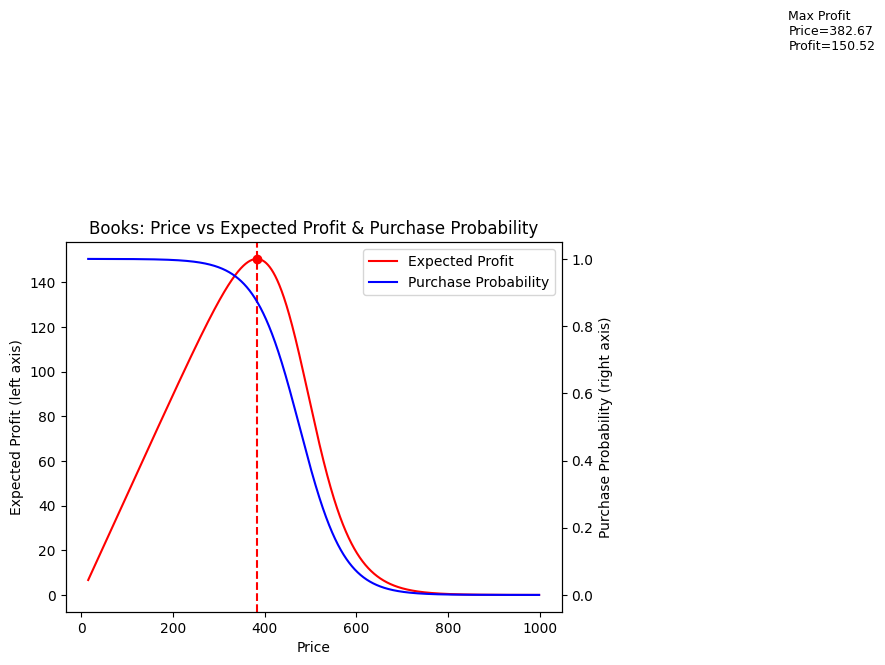

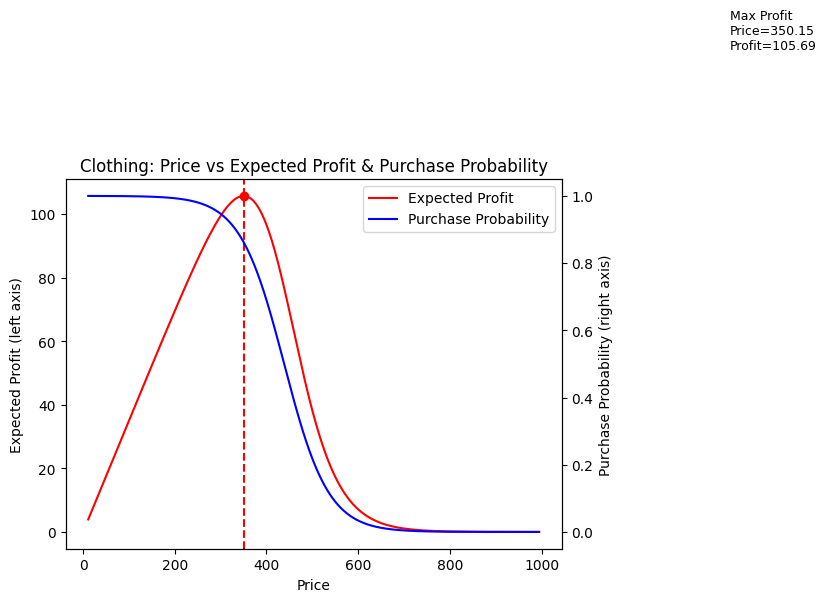

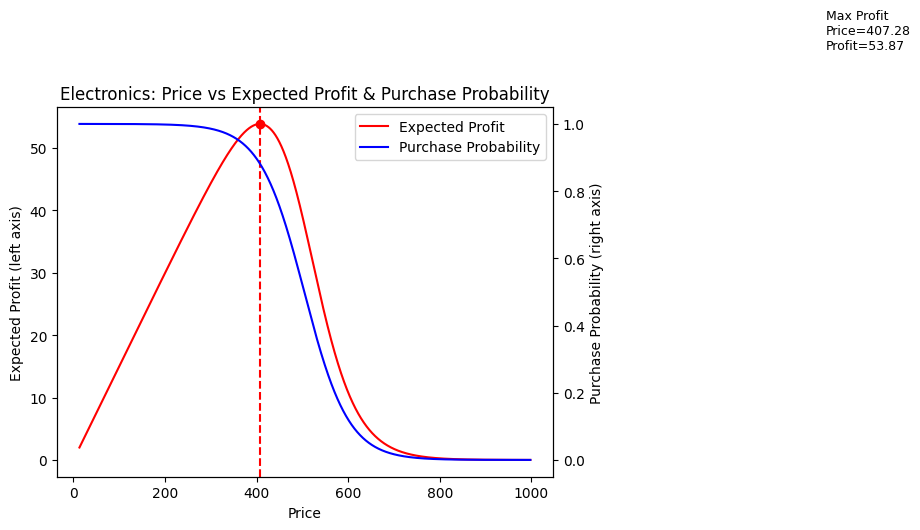

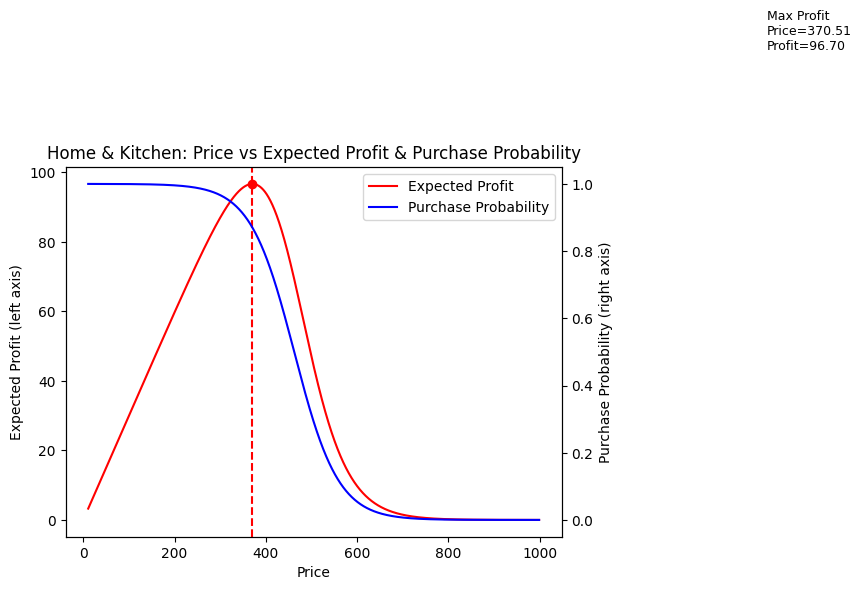

      Category  CostRate  OptimalPrice  PurchaseProb  ExpectedProfit
         Books      0.55        382.67        0.8741        150.5226
      Clothing      0.65        350.15        0.8624        105.6909
   Electronics      0.85        407.28        0.8817         53.8658
Home & Kitchen      0.70        370.51        0.8700         96.7031


In [13]:
#code for calculate and show the expect profit and find max value.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#step1 input cost fraction
cost_rate = {
    "Books": 0.55,
    "Clothing": 0.65,
    "Home & Kitchen": 0.70,
    "Electronics": 0.85
}

#step2 input the typical profiles for each category from Q2
typical_profiles = {
    "Books": {
        "Product_Category": "Books",
        "Discount": 51.57,
        "Customer_Age": 43.0,
        "Review_Rating": 3.0,
        "Customer_Gender": "Male",
        "Payment_Method": "Credit Card",
        "Shipping_Type": "Standard"
    },
    "Clothing": {
        "Product_Category": "Clothing",
        "Discount": 53.54,
        "Customer_Age": 48.0,
        "Review_Rating": 3.0,
        "Customer_Gender": "Male",
        "Payment_Method": "Credit Card",
        "Shipping_Type": "Express"
    },
    "Electronics": {
        "Product_Category": "Electronics",
        "Discount": 56.37,
        "Customer_Age": 44.0,
        "Review_Rating": 3.0,
        "Customer_Gender": "Female",
        "Payment_Method": "Credit Card",
        "Shipping_Type": "Standard"
    },
    "Home & Kitchen": {
        "Product_Category": "Home & Kitchen",
        "Discount": 54.525000000000006,
        "Customer_Age": 43.0,
        "Review_Rating": 3.0,
        "Customer_Gender": "Male",
        "Payment_Method": "Debit Card",
        "Shipping_Type": "Express"
    }
}

#step3 define variables
X_cols = df.drop(columns=[
    "Purchase Probability",
    "Transaction_ID", "Customer_ID", "Product_ID",
    "Purchase_Timestamp"
], errors="ignore").columns
results = []
for cat, base in typical_profiles.items():

#step4 define the range of price (using the range of dataset), and set price as an input for Q2 modelprob
    sub = df[df["Product_Category"] == cat]
    p_min, p_max = sub["Price"].min(), sub["Price"].max()
    price_grid = np.linspace(p_min, p_max, 100000)
    # ↑ price_grid interval was selected to 100000 as price in the pricing.csv are usually ranged from 0-1000 and round to two decimal places
    candidates = pd.DataFrame([base] * len(price_grid))
    candidates["Price"] = price_grid
    candidates = candidates.reindex(columns=X_cols)

#step5 calculate purchase probability and expected profit for each price
    p_buy = modelprob.predict_proba(candidates)[:, 1]
    margin_rate = 1 - cost_rate[cat]
    exp_profit = p_buy * price_grid * margin_rate

#step6 find the max profit and corresponding price
    best_idx = int(np.argmax(exp_profit))
    best_price = float(price_grid[best_idx])
    best_pbuy = float(p_buy[best_idx])
    best_profit = float(exp_profit[best_idx])
    results.append({
        "Category": cat,
        "CostRate": cost_rate[cat],
        "OptimalPrice": round(best_price, 2),
        "PurchaseProb": round(best_pbuy, 4),
        "ExpectedProfit": round(best_profit, 4),
    })

#step7 plot the result redling = expected profit, blue line = purchase probability
    fig, ax1 = plt.subplots()
    #profit
    ax1.plot(price_grid, exp_profit, color="red", label="Expected Profit")
    ax1.set_xlabel("Price")
    ax1.set_ylabel("Expected Profit (left axis)")
    ax1.set_title(f"{cat}: Price vs Expected Profit & Purchase Probability")
    #purchase prob
    ax2 = ax1.twinx()
    ax2.plot(price_grid, p_buy, color="blue", label="Purchase Probability")
    ax2.set_ylabel("Purchase Probability (right axis)")
    #figure decoration
    ax1.scatter([best_price], [best_profit], color="red")
    ax1.axvline(best_price, color="red", linestyle="--")

    ax1.annotate(
        f"Max Profit\nPrice={best_price:.2f}\nProfit={best_profit:.2f}",
        xy=(best_price, best_profit),
        xytext=(best_price, best_profit),
        textcoords="offset points",
        xycoords="data",
        fontsize=9
    )
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    plt.show()

#step8 output the result
res_df = pd.DataFrame(results).sort_values("Category")
print(res_df.to_string(index=False))

Result Interpretation:

Based on the results, we can clearly find the trade-off between price and expected profit, and finally find the maximizes expected profit with optimal price. This confirms that optimal pricing is category-specific and depends on both cost structure and customer purchase behavior.



*   For Books, the optimal price is about 382.67 with an expected profit of 150.52 per customer shown. This category has a relatively lower cost rate, which allows for a higher profit margin.
*   For Clothing, the optimal price is around 350.15, generating an expected profit of 105.69. Compared with Books, Clothing has a higher cost rate, meaning a lower profit margin.
*   For Home & Kitchen, the optimal price is about 370.51 with expected profit of 96.70. The higher cost rate reduces the margin, so the expected profit is lower than Books and Clothing even at similar price levels.
*   Electronics has optimal price is around 407.28, but the maximum expected profit is only about 53.87. This shows that categories with high cost fractions are much more sensitive to margin and generate lower expected profit overall.




# **Q3.b.**

No, the profit-maximizing price identified in part Q3(a) may not always be appropriate. There are two internal reasons regarding the profit-maximizing price that I identified:

*   The optimal prices in Q3(a) are calculated based on short-term expected profit, which only considers immediate transaction margin and purchase probability. It does not consider long-term revenue generated from the same customer.
*   The calculation is based on typical customer/product profiles derived from historical data. This means the profit-maximizing price is based on the company’s current market strategy and current customer behavior patterns. If the firm’s objective changes, the historical data and the model built on it may not fully reflect the new objective, so the price derived from it may not always be reliable.

There are also some external reasons that make the profit-maximizing price and the probability prediction model less precise when considering long-term customer value:

*   Long-term customer value focuses more on customer retention, repeat purchases, and customer satisfaction (such as rating and discount in the dataset, as well as recency, frequency, and monetary factors discussed in last Wednesday’s class). A price that maximizes short-term profit may be relatively high and could reduce future purchase intention or long-term loyalty. As a result, this profit-maximizing price may negatively affect long-term customer value and customer lifetime value.
*   If the firm wants to focus on long-term value, it should consider more variables that capture future customer behavior and its effect on purchase probability, such as retention rate, lifetime value, or customer engagement metrics. These variables are not included in the current dataset and model, which means the optimal price calculated here only reflects short-term transaction-level profit.

If the firm aims to maximize long-term customer value, it may choose a lower or more stable price to maintain customer relationships and encourage repeat purchases, instead of only maximizing profit per transaction. This also reflects the idea discussed in class that pricing decisions depend on business objectives, and there is no single optimal price without considering the firm’s strategic goals.